# Intro

The purpose of my EDA is to find out whether a diet based on animal produts is efficient from a societal perspective.

This means, I'll do a cost-benefit analysis of the food animal sources and compare it to veggie alternatives.

For that purpose, I'll use the following data:
- Resources for food production (cost)
- Nutritional values of the food & recommended daily intake (benefit)

By measuring the relation between resources and nutritional values, we can determine which foods are more efficient.

In [1]:
# Let's import the necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
from varname import nameof

import requests
from bs4 import BeautifulSoup
import html
import lxml

import sys, os

# Helpers
abspath = os.path.abspath
dirname = os.path.dirname
sep = os.sep
file_ = os.getcwd()

ml_folder = dirname(file_)
sys.path.append(ml_folder)

from src.utils import mining_data_tb as md
from src.utils import visualization_tb as vi
from src.utils import folder_tb as fo
from src.utils import models as mo

import warnings
warnings.filterwarnings('ignore')

# Data Cleaning and Transformation

As mentioned before, we'll use three datasets:
- Resources: This is actually composed by several csv files that we will merge
- Nutritional values: It shows +60 nutrients (columns) for +7000 different foods (rows)
- Daily intakes: It is a CSV with the urls of the recommended daily intake according to gender and age. We will do some scrapping here to pull this data

## Resources

In [2]:
#### Data paths
environment_path = fo.path_to_folder(2, "data" + sep + "environment")
resources_path = fo.path_to_folder(2, "data" + sep + "environment" + sep + "resources_use")

#### Load data
general = pd.read_csv(environment_path + "food_production.csv")
general.head()

,Food product,Land use change,Animal Feed,Farm,Processing,Transport,Packging,Retail,Total_emissions,Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal),...,Freshwater withdrawals per 100g protein (liters per 100g protein),Freshwater withdrawals per kilogram (liters per kilogram),Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal),Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein),Land use per 1000kcal (m² per 1000kcal),Land use per kilogram (m² per kilogram),Land use per 100g protein (m² per 100g protein),Scarcity-weighted water use per kilogram (liters per kilogram),Scarcity-weighted water use per 100g protein (liters per 100g protein),Scarcity-weighted water use per 1000kcal (liters per 1000 kilocalories)
0,Wheat & Rye (Bread),0.1,0.0,0.8,0.2,0.1,0.1,0.1,1.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Maize (Meal),0.3,0.0,0.5,0.1,0.1,0.1,0.0,1.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Barley (Beer),0.0,0.0,0.2,0.1,0.0,0.5,0.3,1.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oatmeal,0.0,0.0,1.4,0.0,0.1,0.1,0.0,1.6,4.281357,...,371.076923,482.4,0.945482,1.907692,2.897446,7.6,5.846154,18786.2,14450.92308,7162.104461
4,Rice,0.0,0.0,3.6,0.1,0.1,0.1,0.1,4.0,9.514379,...,3166.760563,2248.4,1.207271,6.267606,0.759631,2.8,3.943662,49576.3,69825.77465,13449.891480


In [3]:
general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 23 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   Food product                                                             43 non-null     object 
 1   Land use change                                                          43 non-null     float64
 2   Animal Feed                                                              43 non-null     float64
 3   Farm                                                                     43 non-null     float64
 4   Processing                                                               43 non-null     float64
 5   Transport                                                                43 non-null     float64
 6   Packging                                                                 43 

Right now, we can already see several things:
- Quite a few NaN values
- Many columns refering to emissions: from "Land use change" to "Retail", they all refer to emissions. As the columns "Total_emissions" is the sum of the previous ones, I'll keep just this one and drop the rest. 
- Additionally, I'm interested in the data of water and land use, as I've found other datasets that can fill some of the missing values.

This is what we are going to do next:
1. Try to fill the missing values using data from other dataframes
2. Filter by the columns we will actually use

In [4]:
# Let's start with the land use data
# The units are squared meters (m2): https://ourworldindata.org/environmental-impacts-of-food?country=#water-use


# Load data and drop the unnecessary columns
land_use_kcal = pd.read_csv(resources_path + "land-use-kcal-poore.csv").drop(["Code", "Year"], axis = 1)
land_use_kg = pd.read_csv(resources_path + "land-use-per-kg-poore.csv").drop(["Code", "Year"], axis = 1)
land_use_protein = pd.read_csv(resources_path + "land-use-protein-poore.csv").drop(["Code", "Year"], axis = 1)

# Merge all the data in one dataframe
land_use = pd.merge(land_use_kcal, land_use_kg, how = "outer", on = "Entity")
land_use = pd.merge(land_use, land_use_protein, how = "outer", on = "Entity")
land_use.columns = ["Entity", "Land use per 1000kcal", "Land use per kg", "Land use per 100g protein"]

land_use.head()

,Entity,Land use per 1000kcal,Land use per kg,Land use per 100g protein
0,Apples,1.312500,0.63,21.000000
1,Bananas,3.216667,1.93,21.444444
2,Barley,0.222000,1.11,NaN
3,Beef (beef herd),119.490842,326.21,163.595787
4,Beef (dairy herd),15.838828,43.24,21.904762


In [5]:
# Let's continue with the water use data
# The units are liters (l): https://ourworldindata.org/environmental-impacts-of-food?country=#water-use


# Load data and drop the unnecessary columns
water_use_kcal = pd.read_csv(resources_path + "freshwater-withdrawals-per-kcal.csv").drop(["Code", "Year"], axis = 1)
water_use_kg = pd.read_csv(resources_path + "freshwater-withdrawals-per-kg.csv").drop(["Code", "Year"], axis = 1)
water_use_protein = pd.read_csv(resources_path + "freshwater-withdrawals-per-protein.csv").drop(["Code", "Year"], axis = 1)

# Merge all the data in one dataframe
water_use = pd.merge(water_use_kcal, water_use_kg, how = "outer", on = "Entity")
water_use = pd.merge(water_use, water_use_protein, how = "outer", on = "Entity")
water_use.columns = ["Entity", "Freswater withdrawls per 1000kcal", "Freswater withdrawls per kg", "Freswater withdrawls per 100g protein"]
water_use.head()

,Entity,Freswater withdrawls per 1000kcal,Freswater withdrawls per kg,Freswater withdrawls per 100g protein
0,Apples,375.208333,180.1,6003.333333
1,Bananas,190.833333,114.5,1272.222222
2,Barley,3.420000,17.1,NaN
3,Beef (beef herd),531.575092,1451.2,727.783350
4,Beef (dairy herd),994.249084,2714.3,1375.025329


In [6]:
# We clean up a little bit the general df before merging
general = general.rename({"Food product" : "Entity", "Total_emissions" : "Total emissions"}, axis = 1)

# Now we merge everything together
resources = pd.merge(general, land_use, how = "outer", on = "Entity")
resources = pd.merge(resources, water_use, how = "outer", on = "Entity")

# Some cleaning and transformation
resources = resources.rename({"Entity" : "Food"}, axis = 1)
resources = resources.set_index("Food")
resources = resources.loc[:, ["Total emissions", 'Land use per 1000kcal', 'Land use per kg', 'Land use per 100g protein', 'Freswater withdrawls per 1000kcal', 'Freswater withdrawls per kg', 'Freswater withdrawls per 100g protein']]

resources.head()

,Total emissions,Land use per 1000kcal,Land use per kg,Land use per 100g protein,Freswater withdrawls per 1000kcal,Freswater withdrawls per kg,Freswater withdrawls per 100g protein
Food,,,,,,,
Wheat & Rye (Bread),1.4,NaN,NaN,NaN,NaN,NaN,NaN
Maize (Meal),1.1,NaN,NaN,NaN,NaN,NaN,NaN
Barley (Beer),1.1,NaN,NaN,NaN,NaN,NaN,NaN
Oatmeal,1.6,2.897446,7.6,5.846154,183.911552,482.4,371.076923
Rice,4.0,0.759631,2.8,3.943662,609.983722,2248.4,3166.760563


In [7]:
# We can find some rows with different names but actually refering to the same product
# For instance
resources.loc[["Tofu", "Tofu (soybeans)"], :]

,Total emissions,Land use per 1000kcal,Land use per kg,Land use per 100g protein,Freswater withdrawls per 1000kcal,Freswater withdrawls per kg,Freswater withdrawls per 100g protein
Food,,,,,,,
Tofu,3.0,NaN,NaN,NaN,NaN,NaN,NaN
Tofu (soybeans),NaN,1.298893,3.52,2.2,54.833948,148.6,92.875


As we can see, by merging both rows, we'd have all the data for this product. So let's do that for all the "duplicated" rows.

In [8]:
# We call the merger object
merger = md.merger()

# We define a list of lists with the rows we want to merge
cols_list = [["Tofu", "Tofu (soybeans)"],
             ["Wheat & Rye", "Wheat & Rye (Bread)"],
             ["Maize", "Maize (Meal)"],
             ["Barley", "Barley (Beer)"]]

# We merge the rows
resources = merger.multiple_merge_cols(resources, cols_list)
resources.index

Index(['Oatmeal', 'Rice', 'Potatoes', 'Cassava', 'Cane Sugar', 'Beet Sugar',
       'Other Pulses', 'Peas', 'Nuts', 'Groundnuts', 'Soymilk', 'Soybean Oil',
       'Palm Oil', 'Sunflower Oil', 'Rapeseed Oil', 'Olive Oil', 'Tomatoes',
       'Onions & Leeks', 'Root Vegetables', 'Brassicas', 'Other Vegetables',
       'Citrus Fruit', 'Bananas', 'Apples', 'Berries & Grapes', 'Wine',
       'Other Fruit', 'Coffee', 'Dark Chocolate', 'Beef (beef herd)',
       'Beef (dairy herd)', 'Lamb & Mutton', 'Pig Meat', 'Poultry Meat',
       'Milk', 'Cheese', 'Eggs', 'Fish (farmed)', 'Shrimps (farmed)',
       'Prawns (farmed)', 'Grains', 'Tofu_', 'Wheat & Rye_', 'Maize_',
       'Barley_'],
      dtype='object')

In [9]:
# Let's rename the merged rows
resources = resources.rename({'Tofu_': "Tofu",
                              'Wheat & Rye_': "Wheat & Rye",
                              'Maize_': "Maize",
                              'Barley_': "Barley"})
resources.index

Index(['Oatmeal', 'Rice', 'Potatoes', 'Cassava', 'Cane Sugar', 'Beet Sugar',
       'Other Pulses', 'Peas', 'Nuts', 'Groundnuts', 'Soymilk', 'Soybean Oil',
       'Palm Oil', 'Sunflower Oil', 'Rapeseed Oil', 'Olive Oil', 'Tomatoes',
       'Onions & Leeks', 'Root Vegetables', 'Brassicas', 'Other Vegetables',
       'Citrus Fruit', 'Bananas', 'Apples', 'Berries & Grapes', 'Wine',
       'Other Fruit', 'Coffee', 'Dark Chocolate', 'Beef (beef herd)',
       'Beef (dairy herd)', 'Lamb & Mutton', 'Pig Meat', 'Poultry Meat',
       'Milk', 'Cheese', 'Eggs', 'Fish (farmed)', 'Shrimps (farmed)',
       'Prawns (farmed)', 'Grains', 'Tofu', 'Wheat & Rye', 'Maize', 'Barley'],
      dtype='object')

In [10]:
# Now that we have all the data in one dataframe, let's have another look at it
resources.describe()

,Total emissions,Land use per 1000kcal,Land use per kg,Land use per 100g protein,Freswater withdrawls per 1000kcal,Freswater withdrawls per kg,Freswater withdrawls per 100g protein
count,43.000000,38.000000,43.000000,32.000000,35.000000,43.000000,30.000000
mean,5.972093,10.959421,26.196279,25.028045,539.618687,929.844186,1353.937285
std,10.501753,26.639846,74.166242,46.172200,718.992448,1299.818742,1398.980245
min,0.200000,0.222000,0.330000,2.010833,0.723982,0.000000,32.375000
25%,0.850000,1.226590,1.445000,3.635780,78.747231,108.500000,353.504525
50%,1.600000,2.785498,3.520000,7.163865,258.437500,414.600000,991.074763
75%,6.000000,4.665239,12.590000,21.559524,687.257771,1229.550000,1832.386339
max,59.600000,119.490842,369.810000,184.812594,3413.009709,5605.200000,6003.333333


In [11]:
resources.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, Oatmeal to Barley
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Total emissions                        43 non-null     float64
 1   Land use per 1000kcal                  38 non-null     float64
 2   Land use per kg                        43 non-null     float64
 3   Land use per 100g protein              32 non-null     float64
 4   Freswater withdrawls per 1000kcal      35 non-null     float64
 5   Freswater withdrawls per kg            43 non-null     float64
 6   Freswater withdrawls per 100g protein  30 non-null     float64
dtypes: float64(7)
memory usage: 2.8+ KB


Great! Now we have less missing values.

Last but not least, we want to differentiate between animal-based and plant-based products. So, let's do that.

In [12]:
# Separate food products into two categories: plant-based and animal-based
plant_based = ['Oatmeal', 'Rice', 'Potatoes', 'Cassava', 'Cane Sugar', 'Beet Sugar',
       'Other Pulses', 'Peas', 'Nuts', 'Groundnuts', 'Soymilk', 'Soybean Oil',
       'Palm Oil', 'Sunflower Oil', 'Rapeseed Oil', 'Olive Oil', 'Tomatoes',
       'Onions & Leeks', 'Root Vegetables', 'Brassicas', 'Other Vegetables',
       'Citrus Fruit', 'Bananas', 'Apples', 'Berries & Grapes', 'Wine',
       'Other Fruit', 'Coffee', 'Dark Chocolate', 'Tofu', 'Wheat & Rye', 'Maize', 'Barley']

animal_based = ['Beef (beef herd)', 'Beef (dairy herd)', 'Lamb & Mutton', 'Pig Meat',
       'Poultry Meat', 'Milk', 'Cheese', 'Eggs', 'Fish (farmed)',
       'Shrimps (farmed)']

# Create a new column: origin
resources["Origin"] = None

# Replace the Nones in the new "Origin" column for the corresponding values, depending on the procedence
resources.loc[plant_based, "Origin"] = "Plant-based"
resources.loc[animal_based, "Origin"] = "Animal-based"
resources["Origin"].value_counts()

Plant-based     33
Animal-based    10
Name: Origin, dtype: int64

Let's do the cleaning for the other dataset before getting to the analysis: nutrition data.

## Nutrition & Daily Intake Data

In [13]:
nutrition_df = pd.read_excel(environment_path + "2017-2018 FNDDS At A Glance - FNDDS Nutrient Values.xlsx", skiprows = 1)
nutrition_df.shape

(7083, 69)

In [14]:
# Let's have a closer look at the columns
nutrition_df.columns

Index(['Food code', 'Main food description', 'WWEIA Category number',
       'WWEIA Category description', 'Energy (kcal)', 'Protein (g)',
       'Carbohydrate (g)', 'Sugars, total\n(g)', 'Fiber, total dietary (g)',
       'Total Fat (g)', 'Fatty acids, total saturated (g)',
       'Fatty acids, total monounsaturated (g)',
       'Fatty acids, total polyunsaturated (g)', 'Cholesterol (mg)',
       'Retinol (mcg)', 'Vitamin A, RAE (mcg_RAE)', 'Carotene, alpha (mcg)',
       'Carotene, beta (mcg)', 'Cryptoxanthin, beta (mcg)', 'Lycopene (mcg)',
       'Lutein + zeaxanthin (mcg)', 'Thiamin (mg)', 'Riboflavin (mg)',
       'Niacin (mg)', 'Vitamin B-6 (mg)', 'Folic acid (mcg)',
       'Folate, food (mcg)', 'Folate, DFE (mcg_DFE)', 'Folate, total (mcg)',
       'Choline, total (mg)', 'Vitamin B-12 (mcg)',
       'Vitamin B-12, added\n(mcg)', 'Vitamin C (mg)',
       'Vitamin D (D2 + D3) (mcg)', 'Vitamin E (alpha-tocopherol) (mg)',
       'Vitamin E, added\n(mg)', 'Vitamin K (phylloquinone) (

As we can see, they are quite messy and we even have some columns, we don't know the meaning of. Let's start by filtering and cleaning them.

In [15]:
### Filtering the columns we'll be using

# Key nutrients for the comparison with recommended daily intake
daily_intake_nutrients = ["Protein (g)", "Water\n(g)", "Fiber, total dietary (g)", "Vitamin A, RAE (mcg_RAE)", "Thiamin (mg)", "Riboflavin (mg)", "Niacin (mg)", "Vitamin B-6 (mg)", "Vitamin B-12 (mcg)",  "Vitamin B-12, added\n(mcg)", "Folate, total (mcg)", "Vitamin C (mg)", "Calcium (mg)", "Iron\n(mg)", "Magnesium (mg)", "Potassium (mg)", "Sodium (mg)", "Zinc\n(mg)"]

# Additional interesting nutrients to explore
additional_nutrients = ["Energy (kcal)", "Sugars, total\n(g)", "Carbohydrate (g)", "Total Fat (g)", "Fatty acids, total saturated (g)", "Fatty acids, total monounsaturated (g)", "Fatty acids, total polyunsaturated (g)", "Cholesterol (mg)", "Vitamin D (D2 + D3) (mcg)"]

# For grouping and categorization
support_columns = ["Main food description", "WWEIA Category number", "WWEIA Category description"]

# Filter the columns
nutrition_df = nutrition_df.loc[:, support_columns + daily_intake_nutrients + additional_nutrients]

In [16]:
# With the columns filtered, we now want to clean them up a bit

# Key nutrients for the comparison with recommended daily intake
cleaned_daily_intake_nutrients = ["Protein (g)", "Water (g)", "Fiber, total dietary (g)", "Vitamin A, RAE (mcg)", "Thiamin (mg)", "Riboflavin (mg)", "Niacin (mg)", "Vitamin B-6 (mg)", "Vitamin B-12 (mcg)",  "Vitamin B-12, added (mcg)", "Folate, total (mcg)", "Vitamin C (mg)", "Calcium (mg)", "Iron (mg)", "Magnesium (mg)", "Potassium (mg)", "Sodium (mg)", "Zinc (mg)"]

# Additional interesting nutrients to explore
cleaned_additional_nutrients = ["Energy (kcal)", "Sugars, total (g)", "Carbohydrate (g)", "Total Fat (g)", "Fatty acids, total saturated (g)", "Fatty acids, total monounsaturated (g)", "Fatty acids, total polyunsaturated (g)", "Cholesterol (mg)", "Vitamin D (D2 + D3) (mcg)"]

# For grouping and categorization
cleaned_support_columns = ["Food name", "Category number", "Category name"]

# Rename the columns
nutrition_df.columns = cleaned_support_columns + cleaned_daily_intake_nutrients + cleaned_additional_nutrients

We have two columns for Vitamin B12:
- Vitamin B-12 (mcg)
- Vitamin B-12, added (mcg)

The first one is the raw amount in the foods and the second one is the added amount. This means, the total amount of this nutrient in the foods will be the sum of both.

In [17]:
# Joining Vitamin B-12 column, as the total value is the sum of the food raw value and the added amount
nutrition_df["Vitamin B-12 (mcg)"] = nutrition_df["Vitamin B-12 (mcg)"] + nutrition_df["Vitamin B-12, added (mcg)"]
# Dropping the two old Vitamin B12 columns, as we now have them together in a new one
nutrition_df.drop(["Vitamin B-12, added (mcg)"], axis = 1, inplace = True)

In [18]:
nutrition_df.columns

Index(['Food name', 'Category number', 'Category name', 'Protein (g)',
       'Water (g)', 'Fiber, total dietary (g)', 'Vitamin A, RAE (mcg)',
       'Thiamin (mg)', 'Riboflavin (mg)', 'Niacin (mg)', 'Vitamin B-6 (mg)',
       'Vitamin B-12 (mcg)', 'Folate, total (mcg)', 'Vitamin C (mg)',
       'Calcium (mg)', 'Iron (mg)', 'Magnesium (mg)', 'Potassium (mg)',
       'Sodium (mg)', 'Zinc (mg)', 'Energy (kcal)', 'Sugars, total (g)',
       'Carbohydrate (g)', 'Total Fat (g)', 'Fatty acids, total saturated (g)',
       'Fatty acids, total monounsaturated (g)',
       'Fatty acids, total polyunsaturated (g)', 'Cholesterol (mg)',
       'Vitamin D (D2 + D3) (mcg)'],
      dtype='object')

As we want to compare animal-based vs plant-based foods and we don't have such category in our dataframe, we'll create it.

In [19]:
# First, we create a filter_tool object to make things easier
filter_tool = md.filter_tool()

# Then, we create several food groups first
milks = filter_tool.food_filter("Milks")
cheese = filter_tool.food_filter("Cheese")
other_animal_products = filter_tool.food_filter("Other Animal Products")
meats = filter_tool.food_filter("Meats")
chicken = filter_tool.food_filter("Chicken")
fish = filter_tool.food_filter("Fish")
milk_substitutes = filter_tool.food_filter("Milk Substitutes")
beans = filter_tool.food_filter("Beans")
soy_products = filter_tool.food_filter("Soy Products")
nuts = filter_tool.food_filter("Nuts")
other_veggie_products = filter_tool.food_filter("Other Veggie Products")

# Now we will create the category
# First we define some parameters to pass in the function
new_category = "Category 2"
initial_value = "Others"
new_values = [["Milks", milks], ["Cheese", cheese], ["Other Animal Products", other_animal_products], ["Meats", meats], ["Chicken", chicken], ["Fish", fish], ["Milk Substitutes", milk_substitutes], ["Beans", beans], ["Soy Products", soy_products], ["Nuts", nuts], ["Other Veggie Products", other_veggie_products]]

# Create category
nutrition_df = filter_tool.create_category(nutrition_df, new_category, initial_value, new_values)

In [20]:
# Let's see if the change actually took place
nutrition_df["Category 2"].value_counts()

Others                   5575
Fish                      434
Chicken                   224
Meats                     222
Other Animal Products     165
Milks                     118
Nuts                       78
Beans                      74
Cheese                     73
Other Veggie Products      72
Milk Substitutes           27
Soy Products               21
Name: Category 2, dtype: int64

In [21]:
# Great! Now let's add a last column to differentiate between plant-based and animal-based
# Same procedure

# Create groups
animal_prod = filter_tool.food_filter("Animal Products")
veggie_prod = filter_tool.food_filter("Veggie Products")

# Parameters to pass into the function
new_category_2 = "Category 3"
initial_value_2 = "Not Classified"
new_values_2 = [["Animal-based", animal_prod], ["Plant-based", veggie_prod]]

# Create category
nutrition_df = filter_tool.create_category(nutrition_df, new_category_2, initial_value_2, new_values_2)

In [22]:
# Let's see if the change actually took place
nutrition_df["Category 3"].value_counts()

Not Classified    5575
Animal-based      1236
Plant-based        272
Name: Category 3, dtype: int64

In [23]:
# To finish, let's set "Food name" as index
nutrition_df = nutrition_df.set_index("Food name")

Now that we are all set, we can start with the exploratory analysis of both datasets

# Data Exploration

## Resources

Let's have a look at the total emissions data for the different foods. This way, we'll see how polluting the food production process is

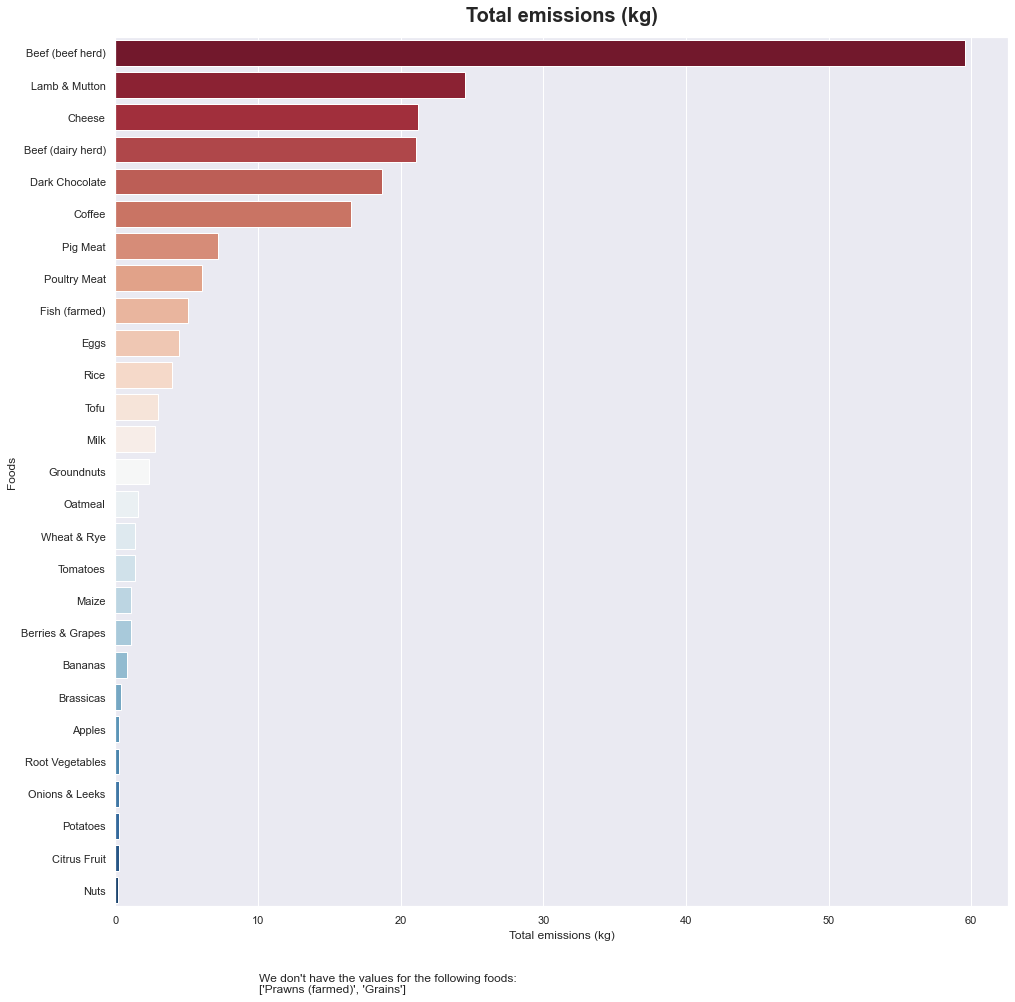

In [24]:
# We plot the data
# For that, I need the plotter object
resources_plotter = vi.resources_plotter()
fig = resources_plotter.resources_plot(data = resources, x = "Total emissions", title = "Total emissions (kg)", figsize = (16, 16))

# Save the plot
environment_reports_path = fo.path_to_folder(2, "reports" + sep + "environment")
#plt.savefig(environment_reports_path + "Total_emissions.pdf")

As we can see, animal-based products are quite polluting.

Let's do the same for land and water use

In those cases, we have more than one column (per kg, per 1000 kcal, per 100g of protein). I'll focus on the cost per kg as it is the best way to compare foods with such a different compositions. To produce 100g of protein based on apples, we would need quite a lot of resources, because that's not one of the key nutrients of that food. It'd be the same as measuring the amount of resources needed to get 100g of fiber from animal sources. Like way too much 

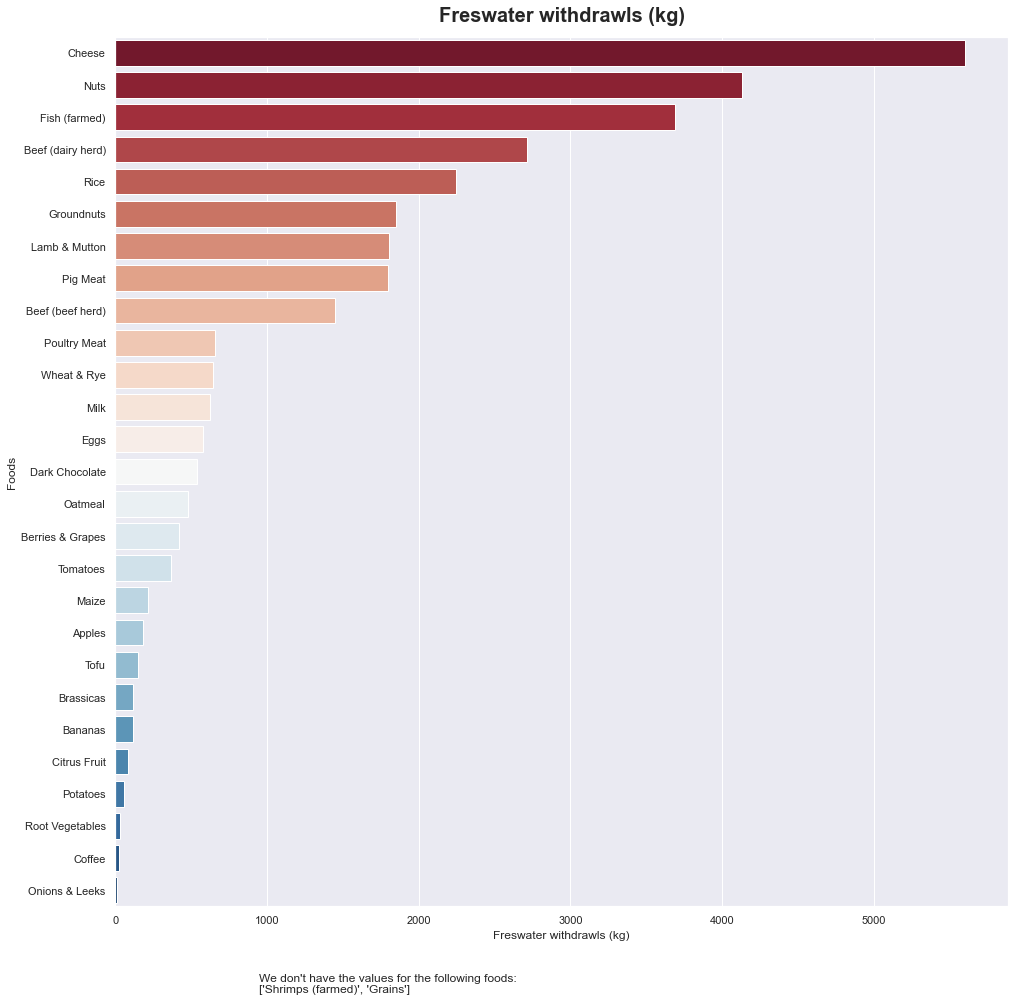

In [25]:
# We plot the data
fig = resources_plotter.resources_plot(data = resources, x = "Freswater withdrawls per kg", title = "Freswater withdrawls (kg)", figsize = (16, 16))

# Save the plot
#plt.savefig(environment_reports_path + "Fresh_water.pdf")

We can see a similar trend as before: animal-based products are quite costly in terms of water.

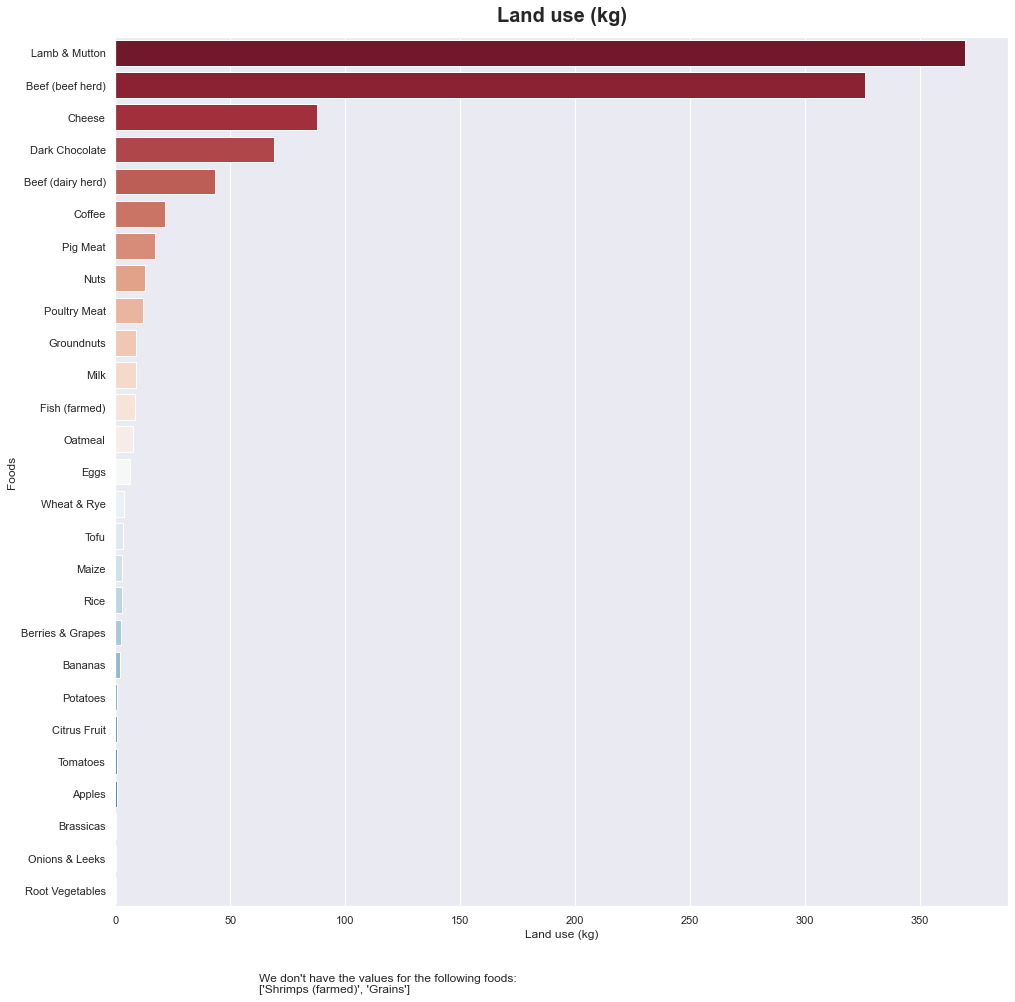

In [26]:
# We plot the data
fig = resources_plotter.resources_plot(data = resources, x = "Land use per kg", title = "Land use (kg)", figsize = (16, 16))

# Save the plot
#plt.savefig(environment_reports_path + "Land_use.pdf")

From this data we can already see how costly animal-based foods are from a resources standpoint compared to their plant-based counterparts.

However, to be as accurate as possible, let's see the center values comparing plant-based with animal-based

In [28]:
resources_list = list(resources.columns[:-1])

# Let's get some insights on this data based on the food Origin
resources_stats = md.resources_stats()
stats = resources_stats.table(resources, resources_list, "Origin")
#stats = resources.groupby("Origin").agg({resource : (np.mean, np.median) for resource in resources_list})
stats.T

Origin                                        Animal-based  Plant-based
Total emissions                       mean       16.390000     2.815152
                                      median      9.500000     1.400000
Land use per 1000kcal                 mean       34.723544     3.609379
                                      median     14.916667     1.714503
Land use per kg                       mean       97.806667     7.370000
                                      median     17.360000     2.410000
Land use per 100g protein             mean       51.590835    15.712814
                                      median     21.904762     5.846154
Freswater withdrawls per 1000kcal     mean      906.822192   292.489784
                                      median    751.380753   176.666667
Freswater withdrawls per kg           mean     2102.944444   531.557576
                                      median   1795.800000   215.700000
Freswater withdrawls per 100g protein mean     1230.689663  1358.090839
                                      median   1109.888752   619.131267

In [41]:
to_plot[to_plot["Measure"] == "median"]

,Resource,Measure,Origin,Values
2,Total emissions,median,Animal-based,9.50
3,Total emissions,median,Plant-based,1.40
6,Land use per kg,median,Animal-based,17.36
7,Land use per kg,median,Plant-based,2.41
10,Freswater withdrawls per kg,median,Animal-based,1795.80
11,Freswater withdrawls per kg,median,Plant-based,215.70


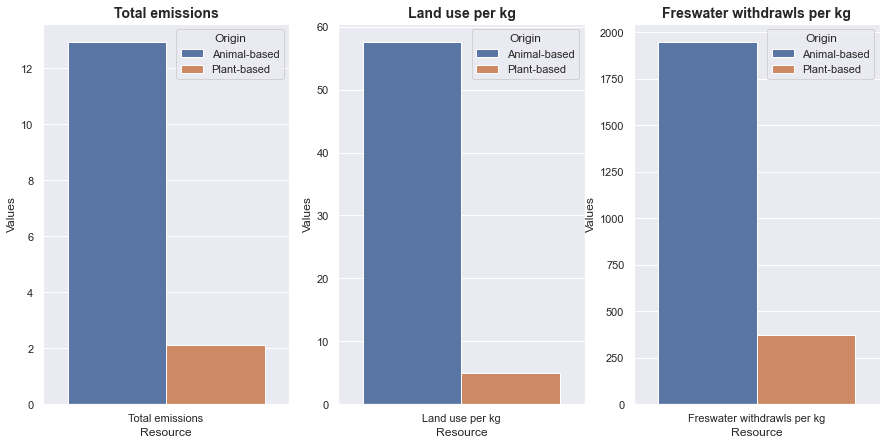

In [29]:
# Now, let's do some transformations, so that we can plot this
# 1) Filter the data to plot
#to_plot = stats.loc[:, ["Total emissions", "Land use per kg", "Freswater withdrawls per kg"]]
# 2) Some extra processing
#to_plot = to_plot.unstack().reset_index()
# 3) Renaming the columns
#to_plot.columns = ["Resource", "Measure", "Origin", "Values"]

to_plot = resources_stats.to_plot(stats, ["Total emissions", "Land use per kg", "Freswater withdrawls per kg"])

# 4) Plot the figure
fig = resources_plotter.stats_plot(to_plot, "Resource", "Values", "Origin")

# Save the plot
#plt.savefig(environment_reports_path + "Resources_stats.pdf")

We can already conclude from this that animal-based products are much more expensive than the plant-based ones, for any category of the analysed ones.

Now, let's move on to the nutritional values analysis to see whether this "cost" difference is justified.

## Nutritional Values & Daily Intake

In [29]:
nutrition_df.columns

Index(['Category number', 'Category name', 'Protein (g)', 'Water (g)',
       'Fiber, total dietary (g)', 'Vitamin A, RAE (mcg)', 'Thiamin (mg)',
       'Riboflavin (mg)', 'Niacin (mg)', 'Vitamin B-6 (mg)',
       'Vitamin B-12 (mcg)', 'Folate, total (mcg)', 'Vitamin C (mg)',
       'Calcium (mg)', 'Iron (mg)', 'Magnesium (mg)', 'Potassium (mg)',
       'Sodium (mg)', 'Zinc (mg)', 'Energy (kcal)', 'Sugars, total (g)',
       'Carbohydrate (g)', 'Total Fat (g)', 'Fatty acids, total saturated (g)',
       'Fatty acids, total monounsaturated (g)',
       'Fatty acids, total polyunsaturated (g)', 'Cholesterol (mg)',
       'Vitamin D (D2 + D3) (mcg)', 'Category 2', 'Category 3'],
      dtype='object')

In [30]:
# Let's start by grouping the foods by the categories we defined earlier
nutrients_list = list(nutrition_df.columns[3:-2])

nutrition_stats = nutrition_df.groupby("Category 2").agg({nutrient : np.mean for nutrient in nutrients_list}).T
nutrition_stats

Category 2,Beans,Cheese,Chicken,Fish,Meats,Milk Substitutes,Milks,Nuts,Other Animal Products,Other Veggie Products,Others,Soy Products
Water (g),60.673784,51.280959,60.545580,63.887604,55.355811,85.346296,73.903644,4.731667,67.593091,58.740278,59.877912,54.651429
"Fiber, total dietary (g)",7.198649,0.100000,0.159375,0.287558,0.153153,0.429630,0.096610,8.097436,0.117576,2.558333,1.864018,3.985714
"Vitamin A, RAE (mcg)",2.459459,167.876712,15.071429,49.997696,135.364865,62.851852,28.550847,16.320513,174.266667,71.875000,73.561256,5.190476
Thiamin (mg),0.147946,0.038397,0.089013,0.123889,0.358748,0.022074,0.083864,0.291718,0.047521,0.192750,0.174190,0.986667
Riboflavin (mg),0.072365,0.326178,0.203741,0.150747,0.323032,0.104370,0.252644,0.296808,0.358691,0.130958,0.178326,0.317095
Niacin (mg),0.620784,0.257000,6.596643,4.530237,5.481968,0.346074,2.443559,5.365897,0.367958,2.924569,2.321376,4.460524
Vitamin B-6 (mg),0.158378,0.091808,0.402201,0.286878,0.351568,0.030222,0.138373,0.375179,0.156812,0.152431,0.178717,0.400905
Vitamin B-12 (mcg),0.019730,1.082877,0.473080,3.589263,2.065045,0.812222,1.562288,0.001667,0.633273,0.088194,0.603300,2.456190
"Folate, total (mcg)",98.540541,15.246575,10.468750,18.352535,17.369369,5.703704,9.093220,81.217949,28.903030,36.069444,43.820807,68.047619
Vitamin C (mg),1.077027,0.345205,0.177679,1.040783,2.112162,0.470370,0.703390,1.050000,0.928485,0.547222,6.977686,0.485714


Well, here we can see some information, but it is difficult to determine anything

Let's visualize for instance, milks vs substitutes and see what nutrients they both have. For that purpose, I'll bring the recommended daily intake of nutrients data. This way we can compare, how much these foods fullfill the nutrition requirements

In [31]:
# Load dataframe where we have the daily intakes info
daily_intake_path = environment_path + "daily_intakes.csv"
di_df = pd.read_csv(daily_intake_path)      # di -> Daily Intake

# We will use a 30 years old male for this example
# For that, I'll create an object to get the daily intake data
di = md.daily_intake()
di_male_30 = di.get_data(di_df, "male", 30)
di_male_30

Protein (g)                   64.0
Water (g)                   2300.0
Fiber, total dietary (g)      30.0
Vitamin A, RAE (mcg)         900.0
Thiamin (mg)                   1.2
Riboflavin (mg)                1.3
Niacin (mg)                   16.0
Vitamin B-6 (mg)               1.3
Vitamin B-12 (mcg)             2.4
Folate, total (mcg)          400.0
Vitamin C (mg)                45.0
Calcium (mg)                1000.0
Iron (mg)                      8.0
Magnesium (mg)               400.0
Potassium (mg)              3800.0
Sodium (mg)                  460.0
Zinc (mg)                     14.0
Name: Daily Intake, dtype: float64

In [32]:
# Now that we have the recommended daily intake for a 30 years old man, we just need to compare this with the food groups' nutrients
# For this, I'll call another object: comparator
foods = [nutrition_stats[column] for column in ["Milks", "Milk Substitutes"]]
comparator = md.comparator(foods, di_male_30)

# Let's see the data
comparator.daily_intake_table()

,Daily Intake,Milks,Milk Substitutes,Relative - Milks (%),Relative - Milk Substitutes (%)
Protein (g),64.0,NaN,NaN,NaN,NaN
Water (g),2300.0,73.903644,85.346296,3.213202,3.710709
"Fiber, total dietary (g)",30.0,0.096610,0.429630,0.322034,1.432099
"Vitamin A, RAE (mcg)",900.0,28.550847,62.851852,3.172316,6.983539
Thiamin (mg),1.2,0.083864,0.022074,6.988701,1.839506
Riboflavin (mg),1.3,0.252644,0.104370,19.434159,8.028490
Niacin (mg),16.0,2.443559,0.346074,15.272246,2.162963
Vitamin B-6 (mg),1.3,0.138373,0.030222,10.644068,2.324786
Vitamin B-12 (mcg),2.4,1.562288,0.812222,65.095339,33.842593
"Folate, total (mcg)",400.0,9.093220,5.703704,2.273305,1.425926


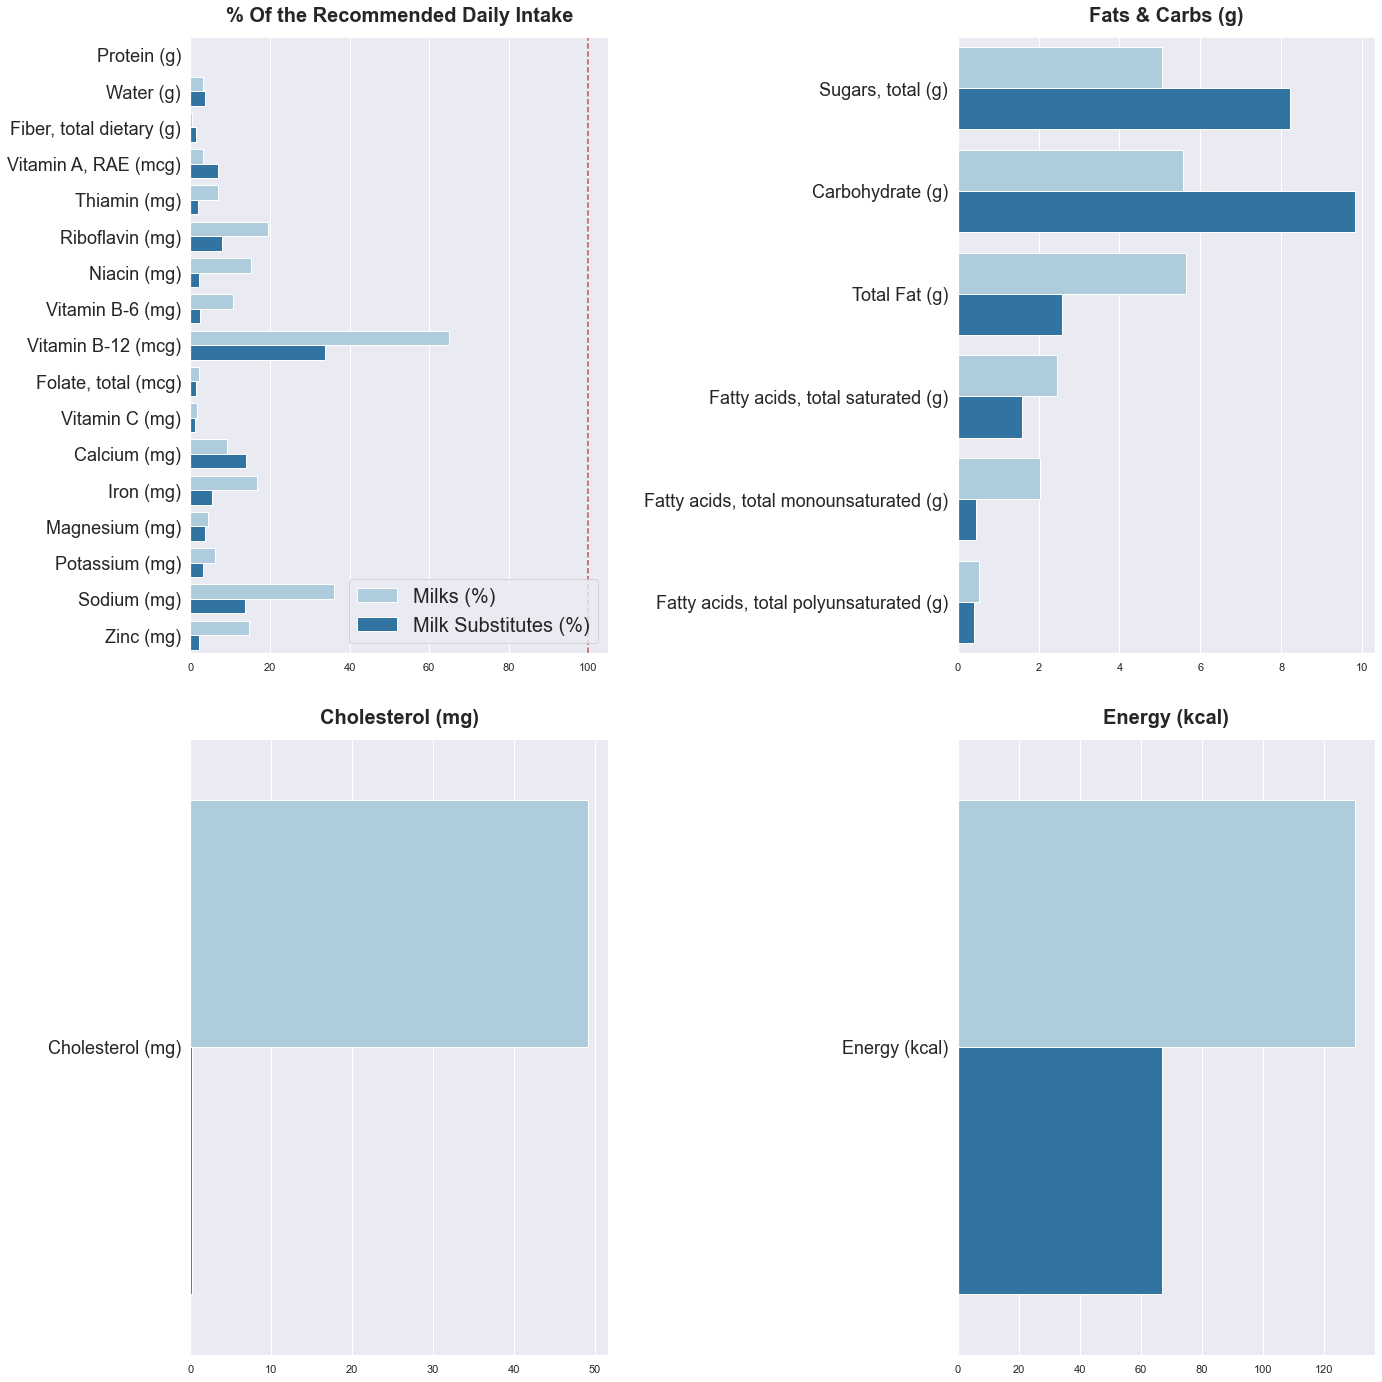

In [33]:
# Let's plot this
comparisons = comparator.get_comparisons()

fig = vi.full_comparison_plot(comparisons)
plt.savefig(environment_reports_path + "Milks_vs_substitutes.pdf")

Quick comment on the plot:
- left-up : we see what percentage of the daily intake these foods are filling with 100g. This means, if Iron is 20% for a given food, that means, 100g of that specific food are getting us 20% of our iron need. Unit : %

- right-up : here we can see how many grams of carbohydrate and the different fats both nutrients have. Notice that "total fat" equals the sum of the rest of the fats.  Unit : g

- left-down : here we can see a cholesterol comparison. Unit : mg

- right-down : the energy value. Unit : kcal

Well, here we can see that the traditional milk is over the veggie substitutes when talking about: protein, vitamin B12, Sodium, Zinc, etc... 

On the other hand, we can also see that the traditional milk is more fat-loaded and they have higher calories.

However, as the range of products included in both milk_substitutes and milks varies a lot (for instance, milks includes yogurts and milk_substitutes includes several kinds of milk, like soy, almond, coconut, etc..), let's compare soy milk with any standard milk, to see what that looks like.

In [41]:
nutrition_df.loc["Soy milk", "Protein (g)":"Vitamin D (D2 + D3) (mcg)"]

Protein (g)                                 2.6
Water (g)                                 90.36
Fiber, total dietary (g)                    0.2
Vitamin A, RAE (mcg)                         55
Thiamin (mg)                              0.029
Riboflavin (mg)                           0.184
Niacin (mg)                               0.425
Vitamin B-6 (mg)                          0.031
Vitamin B-12 (mcg)                          1.7
Folate, total (mcg)                           9
Vitamin C (mg)                              0.0
Calcium (mg)                                123
Iron (mg)                                  0.42
Magnesium (mg)                               15
Potassium (mg)                              122
Sodium (mg)                                  47
Zinc (mg)                                  0.26
Energy (kcal)                                43
Sugars, total (g)                          3.65
Carbohydrate (g)                           4.92
Total Fat (g)                           

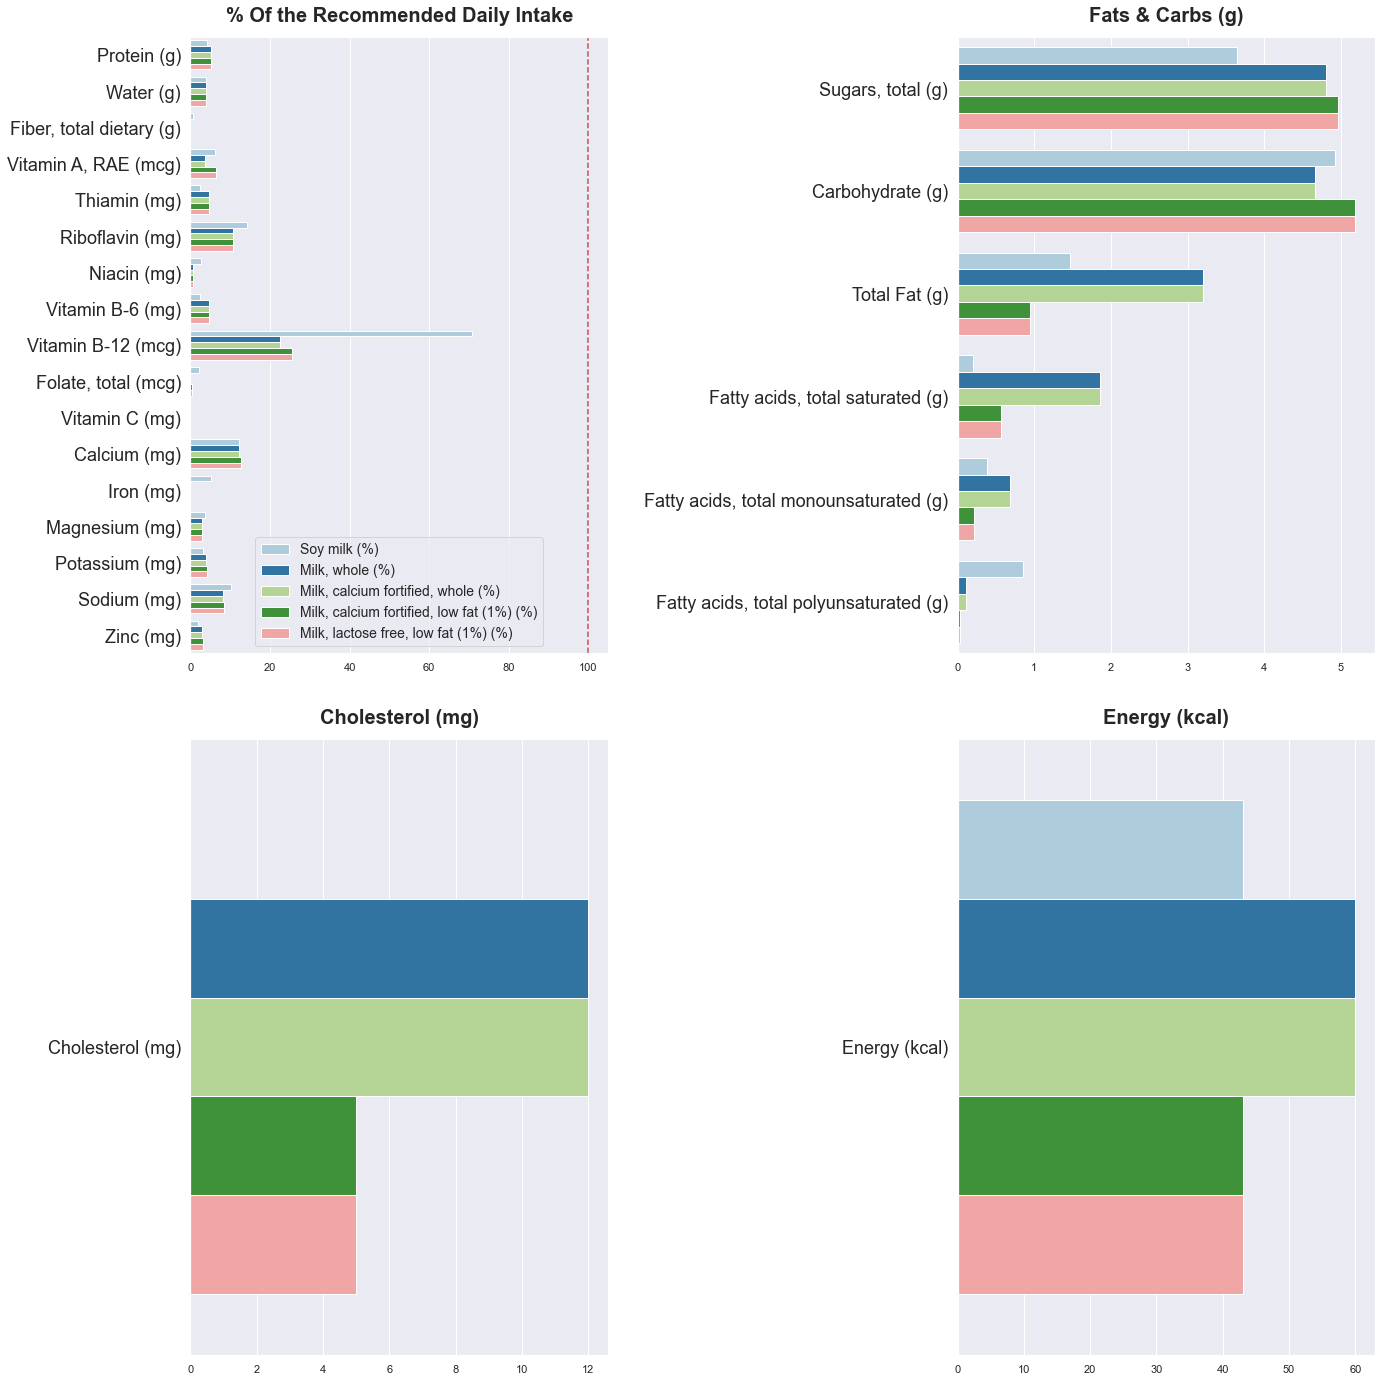

In [47]:
food_items = ["Soy milk", "Milk, whole", "Milk, calcium fortified, whole",
        "Milk, calcium fortified, low fat (1%)", "Milk, lactose free, low fat (1%)"]
foods2 = [nutrition_df.loc[row, "Protein (g)":"Vitamin D (D2 + D3) (mcg)"] for row in food_items]


comparator2 = md.comparator(foods2, di_male_30)

# Let's plot this
comparisons2 = comparator2.get_comparisons()

fig = vi.full_comparison_plot(comparisons2, legendsize = 14)
plt.savefig(environment_reports_path + "Milks_comparison.pdf")

Now we can see better how soy milk not only is as nutritional as other milks, but it even outperform most of milks in several categories, such as: Vitamin-A, Riboflavin, Vitamin-B12. And on top of all this, at a lower saturated-fat cost (I focus on this one because it's the one that should be avoided).

Now let's do this with the different types of meat and their veggie counterparts.

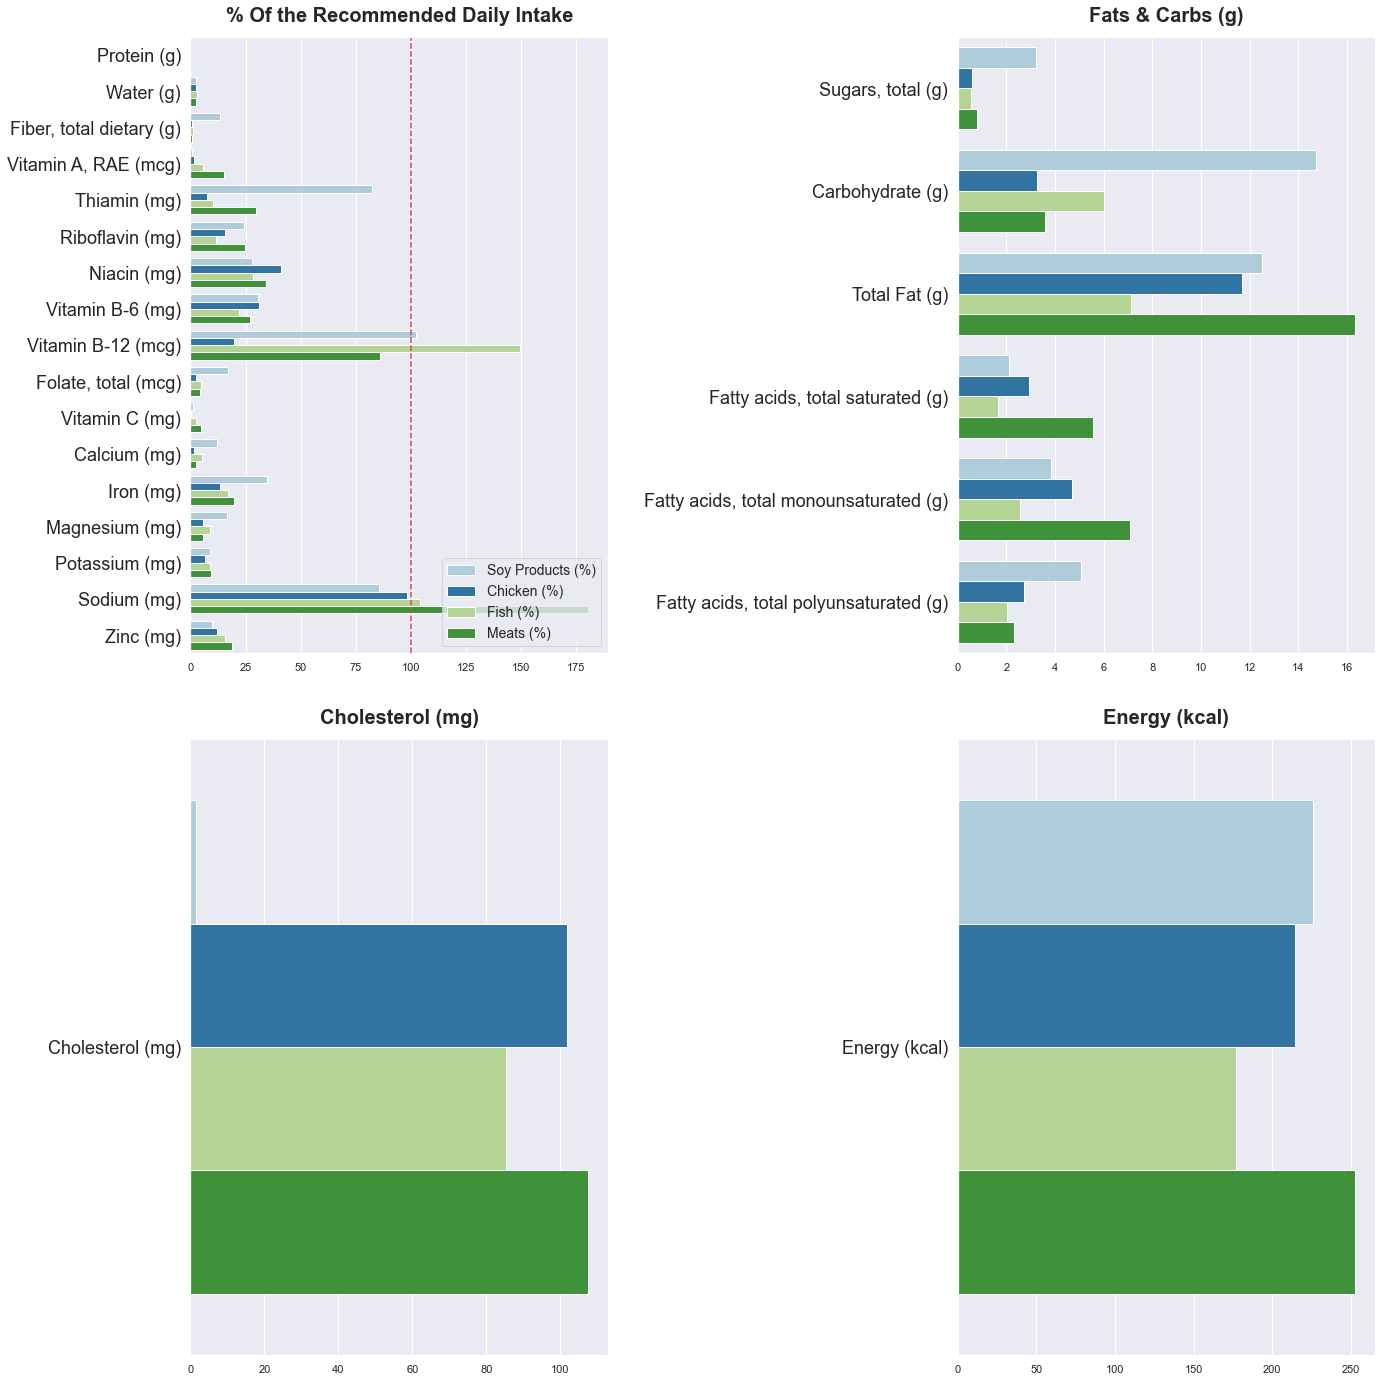

In [48]:
# We'll do this comparison on a food group level once again
foods3 = [nutrition_stats[column] for column in ["Soy Products", "Chicken", "Fish", "Meats"]]

comparator3 = md.comparator(foods3, di_male_30)

# Let's plot this
comparisons3 = comparator3.get_comparisons()

fig = vi.full_comparison_plot(comparisons3, legendsize = 14)
plt.savefig(environment_reports_path + "Animal_vs_soy.pdf")

Now, several things we can comment on:

1 - Soy products have (in general) less protein than those coming from animal sources. However, we can see that the difference is no bigger than 10-15% in terms of filling the recommended daily intake. If we go back in the file, we will see that the cost of producing meat compared to tofu for instance, is way higher. So, it is clearly not an efficient option. We'll go deeper in to that.

2 - Soy products have half of the Vitamin B12, but 100g still help us reach above 50% of the necessary.

3 - Soy products are rich fiber, whereas no animal-product have any fiber.

4 - As before with the milk, we can see that the fat distribution for soy products goes mainly to unsaturated fats, performing better than almost anything but fish.

5 - Cholesterol based, it's definitely the best option.

# Conclusions

We could go on with the comparisons, for instance with beans, as they are a very interesting option from a nutritional standpoint. However, we'll leave it here.

To conclude: we could see that animal-based options definitely have some advantages. This is undeniable. However, from a efficiency perspective, we (as socieaty) pay a too high price for these products, when we could find the missing nutrients in other cheaper (and also nutritious) options.